Pull life expectancy data from Kaggle DB

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
# create connection to db and pull table data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

First step is to identify any problems with the dataset including:
- missing values
- possible outliers

In [3]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
# Clean up variable names
lifeexpectancy_df.rename(inplace=True, columns=lambda x: x.strip())
fill_list = lifeexpectancy_df.columns

# How could I add ONLY the field names with null values to the 'fill_list' variable?

print(fill_list)

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


## Discuss how we handle missing values here

Identify a technique to fill the missing values and explain why you chose said technique

In [5]:
# lifeexpectancy_df.isnull()

null_df = lifeexpectancy_df.isnull().sum()*100/lifeexpectancy_df.isnull().count()

null_df.sort_values(ascending=False)

# new_list = pd.DataFrame(lifeexpectancy_df.isnull().count().reset_index())

# new_list[new_list[0]>0]

Population                         22.191967
Hepatitis B                        18.822328
GDP                                15.248468
Total expenditure                   7.692308
Alcohol                             6.603131
Income composition of resources     5.684139
Schooling                           5.547992
BMI                                 1.157250
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Diphtheria                          0.646698
Polio                               0.646698
Adult Mortality                     0.340368
Life expectancy                     0.340368
under-five deaths                   0.000000
HIV/AIDS                            0.000000
Measles                             0.000000
percentage expenditure              0.000000
infant deaths                       0.000000
Status                              0.000000
Year                                0.000000
Country                             0.000000
dtype: flo

We can see from the above list of fields there are some missing values in our data so we will need to decide how to handle them.

* The most important field we need to decide on is our _Life expectancy_ field as that is our target variable

In [6]:
# Take a quick peek at the raw data from rows with some of the missing values

lifeexpectancy_df[lifeexpectancy_df['Life expectancy'].isnull()].head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1651,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1716,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1813,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1910,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1959,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2168,Saint Kitts and Nevis,2013,Developing,NaN,NaN,0,8.54,0.000000,97.0,0,...,96.0,6.14,96.0,0.1,NaN,NaN,3.7,3.6,0.749,13.4
2217,San Marino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


since there are only 10 rows missing from the _Life expectancy_ dataset we chose to remove the records

In [7]:
clean_lifeexpectancy_df = lifeexpectancy_df.copy()

clean_lifeexpectancy_df.dropna(subset=['Life expectancy'], inplace=True)

# Check the new null record sums
(clean_lifeexpectancy_df.isnull().sum()*100/clean_lifeexpectancy_df.isnull().count()).sort_values(ascending=False)

Population                         21.994536
Hepatitis B                        18.886612
GDP                                15.129781
Total expenditure                   7.718579
Alcohol                             6.591530
Schooling                           5.464481
Income composition of resources     5.464481
BMI                                 1.092896
thinness  1-19 years                1.092896
thinness 5-9 years                  1.092896
Diphtheria                          0.648907
Polio                               0.648907
under-five deaths                   0.000000
HIV/AIDS                            0.000000
Measles                             0.000000
percentage expenditure              0.000000
infant deaths                       0.000000
Adult Mortality                     0.000000
Life expectancy                     0.000000
Status                              0.000000
Year                                0.000000
Country                             0.000000
dtype: flo

In [8]:
# Create a List of all of the variables that have missing values
fill_list = ['Population', 'Hepatitis B', 'GDP', 'Total expenditure', 'Alcohol', 'Schooling',
             'Income composition of resources', 'BMI', 'thinness  1-19 years', 'thinness 5-9 years',
             'Diphtheria','Polio']

There is a high amount of missing Population values so we're going to take a deeper look by Year and Country to see if we can find any themes to why the data might be missing

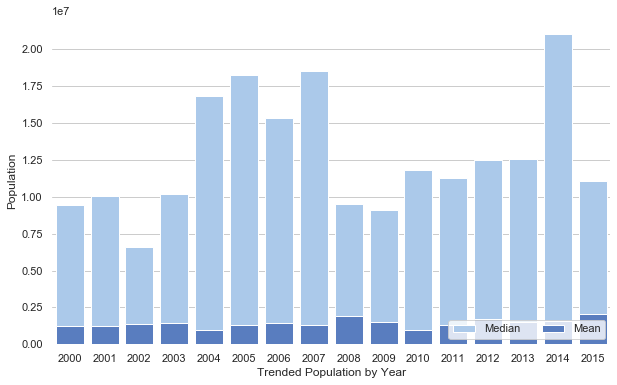

In [9]:
median_data = (clean_lifeexpectancy_df.groupby(['Year'])['Population'].median().reset_index()).sort_values('Population', ascending=False)

mean_data = (clean_lifeexpectancy_df.groupby(['Year'])['Population'].mean().reset_index()).sort_values('Population', ascending=False)

sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Plotting the total Entries
sns.set_color_codes("pastel")
sns.barplot(x="Year", y="Population", data=mean_data,
            label="Median", color="b")

# Plotting the Commercial Entries Per State
sns.set_color_codes("muted")
sns.barplot(x="Year", y="Population", data=median_data,
            label="Mean", color="b")

# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(#xlim=(0, 100000000), ylabel="",
       xlabel="Trended Population by Year")
sns.despine(left=True, bottom=True)

From the above analysis we can see that the mean population data is skewed fairly equally across all years. Lets take a look at the data by Country to see if we can find any trends.

In [10]:
# Check nulls counts by country

# pd.DataFrame(clean_lifeexpectancy_df.groupby(['Country'])[fill_list].mean()).isnull().sum()

# Each country SHOULD have populations for each year
total_years = clean_lifeexpectancy_df.Year.nunique()

country_df = clean_lifeexpectancy_df.groupby(['Country', 'Year'])['Population'].count().reset_index()

# find the countries that do not have Populations 
country_totals = country_df.groupby(['Country'])['Population'].sum().reset_index()

no_population_countries = 0

for i, country in enumerate(country_totals['Country']):    
    if country_totals['Population'][i] == 0:
        no_population_countries = no_population_countries + 1
#         print(country)

print('\n There are {} countries that have 0 out 16 years worth of population data (out of a total {} countries) but the rest look to not be missing'.format(no_population_countries, clean_lifeexpectancy_df.Country.nunique()))


 There are 40 countries that have 0 out 16 years worth of population data (out of a total 183 countries) but the rest look to not be missing


In [11]:
clean_lifeexpectancy_df.head(50)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


We will use the interpolation technique to fill in our missing values for this dataset as it is time series based data and the records in the dataset are ordered all ordered chronologically.

In [12]:
for col in fill_list:
    clean_lifeexpectancy_df.loc[:, col] = clean_lifeexpectancy_df.loc[:, col].interpolate()

(clean_lifeexpectancy_df.isnull().sum()*100/clean_lifeexpectancy_df.isnull().count()).sort_values(ascending=False)

clean_lifeexpectancy_df.dropna(inplace=True)

## Handling Outliers

In [13]:
# See if there are any quick insights from some basic statistics
clean_lifeexpectancy_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,2928,183,Slovenia,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,2928,NaN,NaN,NaN,2007.5,4.61056,2000,2003.75,2007.5,2011.25,2015
Status,2928,2,Developing,2416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Life expectancy,2928,NaN,NaN,NaN,69.2249,9.52387,36.3,63.1,72.1,75.7,89
Adult Mortality,2928,NaN,NaN,NaN,164.796,124.292,1,74,144,228,723
infant deaths,2928,NaN,NaN,NaN,30.4074,118.114,0,0,3,22,1800
Alcohol,2928,NaN,NaN,NaN,4.56404,3.99036,0.01,0.95,3.715,7.56,17.87
percentage expenditure,2928,NaN,NaN,NaN,740.321,1990.93,0,4.85396,65.6115,442.614,19479.9
Hepatitis B,2928,NaN,NaN,NaN,78.3494,25.1714,1,70.5,89,96,99
Measles,2928,NaN,NaN,NaN,2427.86,11486,0,0,17,362.25,212183


Index(['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


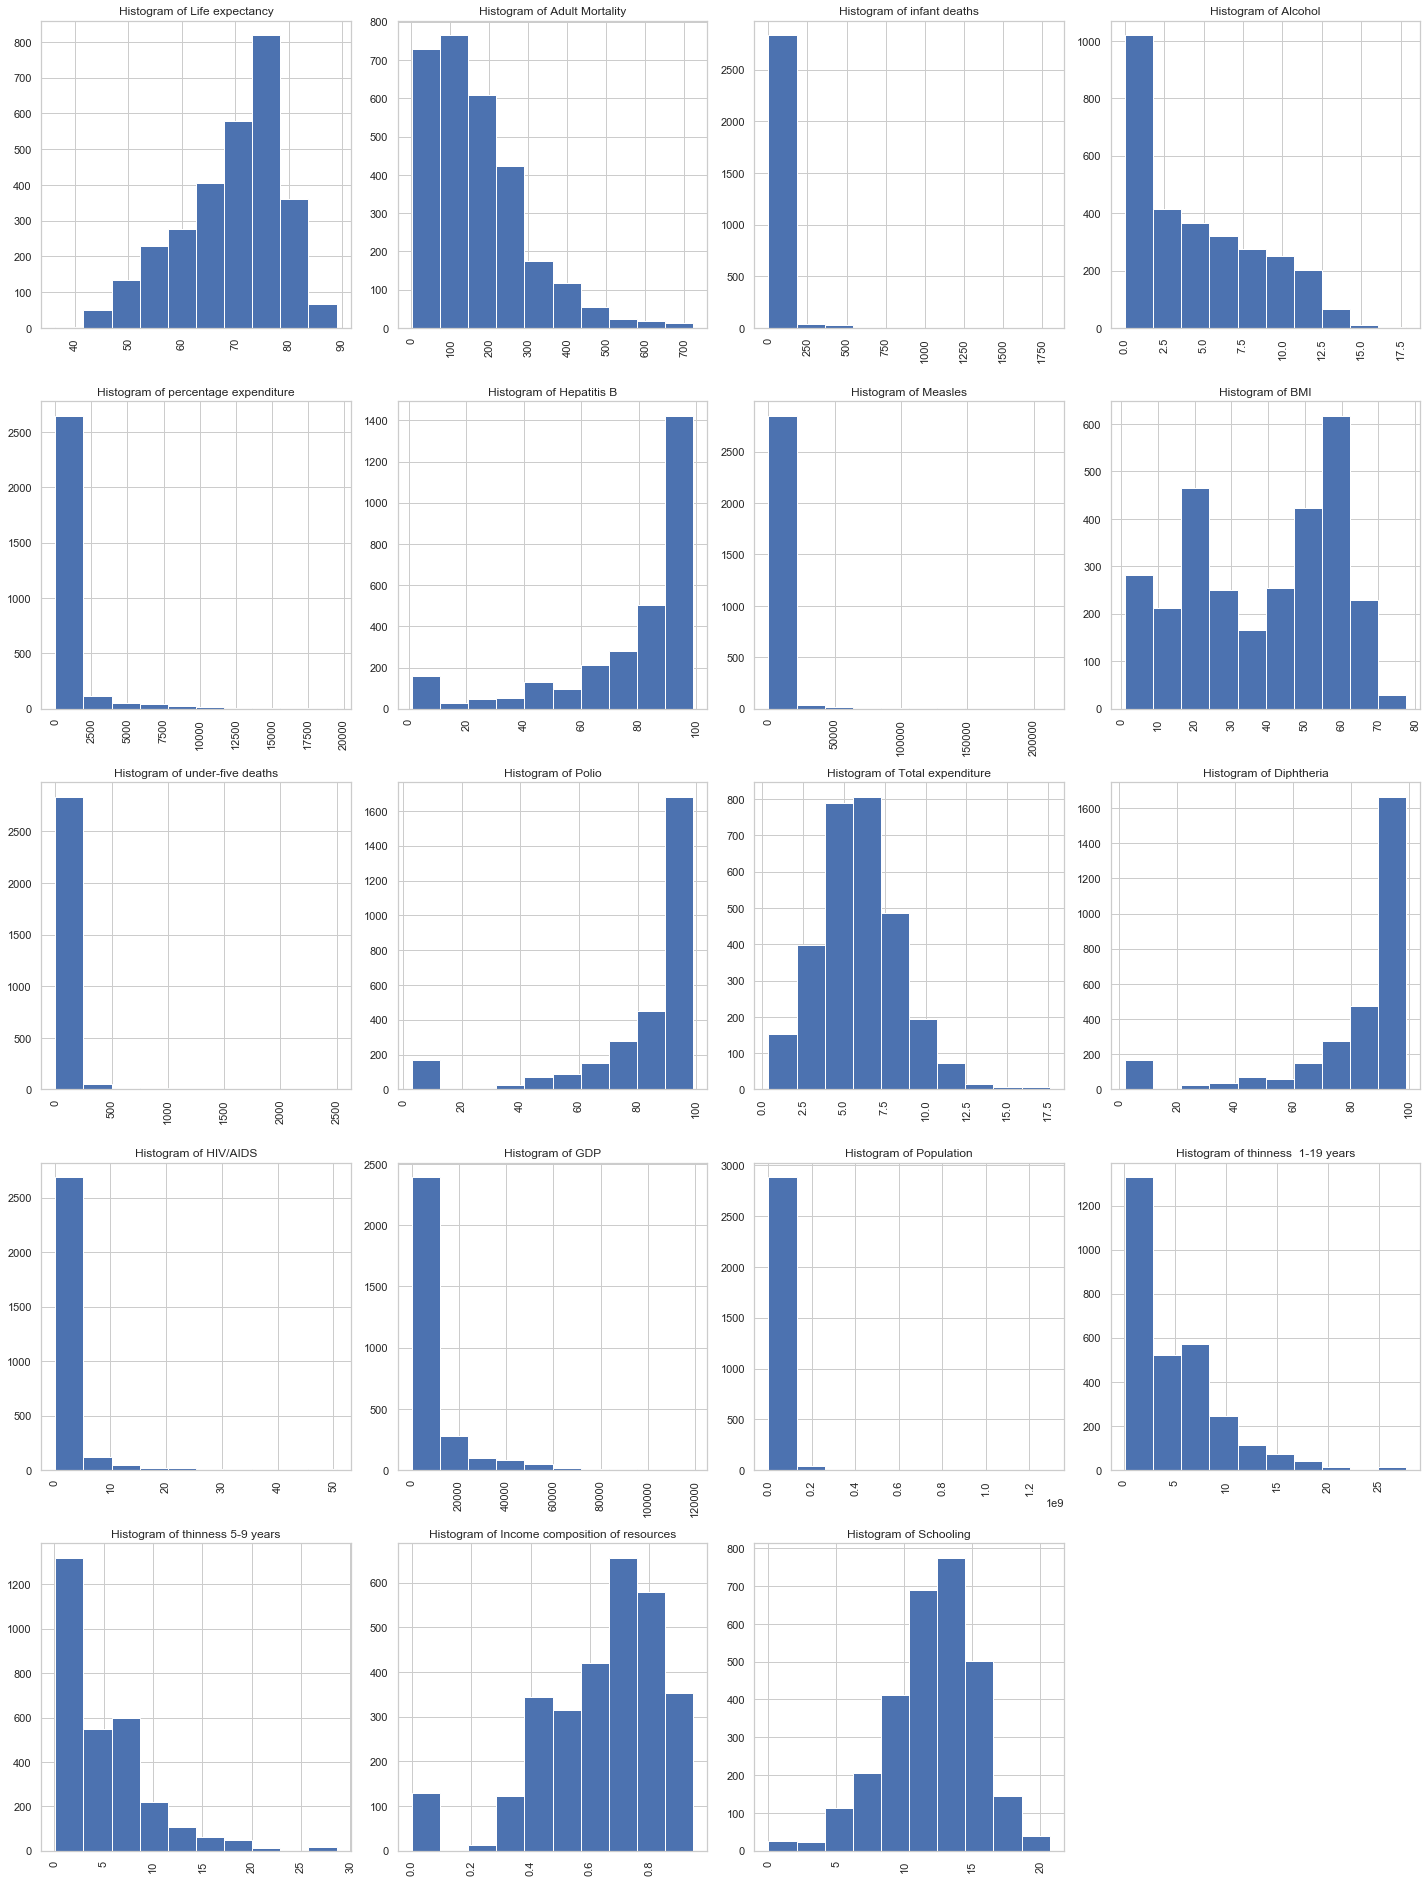

In [14]:
fig = plt.figure(figsize=(20,100))

columns_list = clean_lifeexpectancy_df.columns
columns_list = columns_list[3:]

print(columns_list)

for i, col in enumerate(columns_list):
    df = clean_lifeexpectancy_df[col]
    
    plt.subplot(len(columns_list), 4, i+1)
    plt.hist(df)
    plt.xticks(rotation='vertical')
    plt.title('Histogram of {}'.format(columns_list[i]))
    
plt.tight_layout()
plt.show()

To make this analysis easier to digest we're going to rollup these variables into 5 variables that encapsulate the following broad category levels:

**- "Disease Factors"**
    * Hepatitus B
    * Measles
    * Polio
    * Diphtheria
    * HIV/AIDS
**- "Mortality Factors"**
    * Adult Mortality
    * infant deaths
    * under-five deaths
**- "Economical Factors"**
    * GDP
    * Population
    * Total Expenditures
    * Income composition of resources
    * percentage expenditure
**- "Social Factors"**
    * Schooling
    * Alcohol
**- "Health Factors"**
    * thinness 1-19 years
    * thinness 5-9 years
    * BMI
    
**"Be Strange but don't be a stranger"**

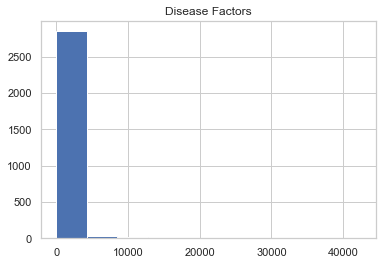

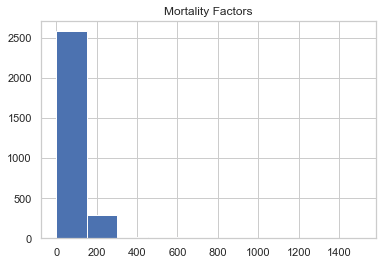

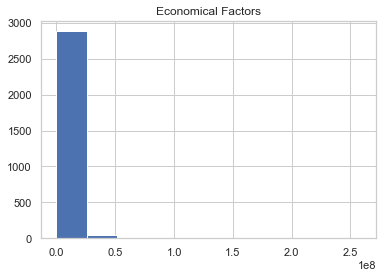

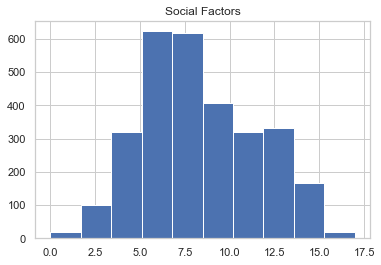

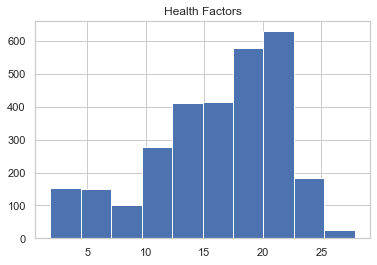

In [48]:
clean_lifeexpectancy_df['Disease Factors'] = disease_factors = (
    clean_lifeexpectancy_df['Hepatitis B'] + clean_lifeexpectancy_df['Measles'] + clean_lifeexpectancy_df['Polio']
+ clean_lifeexpectancy_df['Diphtheria'] + clean_lifeexpectancy_df['HIV/AIDS'])/5

plt.hist(disease_factors)
plt.title('Disease Factors')
plt.show()


clean_lifeexpectancy_df['Mortality Factors'] = mortality_factors = (
    clean_lifeexpectancy_df['Adult Mortality'] + clean_lifeexpectancy_df['infant deaths'] + clean_lifeexpectancy_df['under-five deaths']
)/3

plt.hist(mortality_factors)
plt.title('Mortality Factors')
plt.show()

clean_lifeexpectancy_df['Economical Factors'] = economical_factors = (
    clean_lifeexpectancy_df['GDP'] + clean_lifeexpectancy_df['Population'] + clean_lifeexpectancy_df['Total expenditure']
    + clean_lifeexpectancy_df['Income composition of resources'] + clean_lifeexpectancy_df['percentage expenditure']
)/5

plt.hist(economical_factors)
plt.title('Economical Factors')
plt.show()


clean_lifeexpectancy_df['Social Factors'] = social_factors = (
    clean_lifeexpectancy_df['Schooling'] + clean_lifeexpectancy_df['Alcohol'])/2

plt.hist(social_factors)
plt.title('Social Factors')
plt.show()


clean_lifeexpectancy_df['Health Factors'] = health_factors = (
    clean_lifeexpectancy_df['thinness  1-19 years'] + clean_lifeexpectancy_df['thinness 5-9 years'] + clean_lifeexpectancy_df['BMI']
)/3

plt.hist(health_factors)
plt.title('Health Factors')
plt.show()

## Based on the _Life expectancy_ variable how should we handle outliers in this analysis?

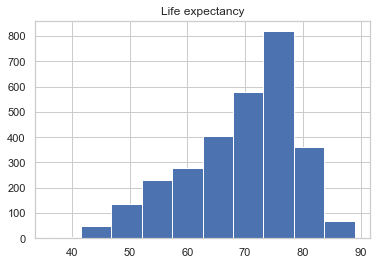

Jarque-Bera test statistics is 205.61247743959427 and p value is 0.0
Normality test statistics is 177.35500491008625 and p value is 3.075034656878767e-39


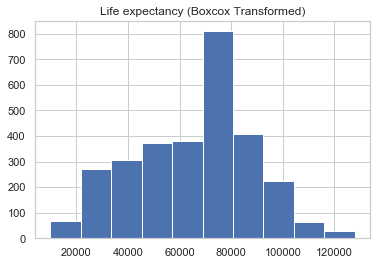

Jarque-Bera test statistics is 42.42531302384114 and p value is 6.12999762061861e-10
Normality test statistics is 77.70452422751855 and p value is 1.338680553287838e-17


In [49]:
clean_lifeexpectancy_df['Boxcox Life expectancy'],_ = boxcox_life_expectancy = boxcox(clean_lifeexpectancy_df['Life expectancy'])

plt.hist(clean_lifeexpectancy_df['Life expectancy'])
plt.title('Life expectancy')
plt.show()

jb_stats = jarque_bera(clean_lifeexpectancy_df['Life expectancy'])
norm_stats = normaltest(clean_lifeexpectancy_df['Life expectancy'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

plt.hist(clean_lifeexpectancy_df['Boxcox Life expectancy'])
plt.title('Life expectancy (Boxcox Transformed)')
plt.show()



jb_stats = jarque_bera(clean_lifeexpectancy_df['Boxcox Life expectancy'])
norm_stats = normaltest(clean_lifeexpectancy_df['Boxcox Life expectancy'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

We can see that by transforming our target variable _Life expectancy_ using the 'Boxcox' technique we have removed our outliers and set a normal distributions for our target with a significance level within 0.05. We will use this transformation technique for our other variables if they are not already normally distributed.

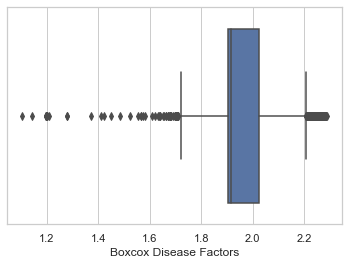

Jarque-Bera test statistics is 2399.8201893017886 and p value is 0.0
Normality test statistics is 320.9533764854153 and p value is 2.022366310949588e-70


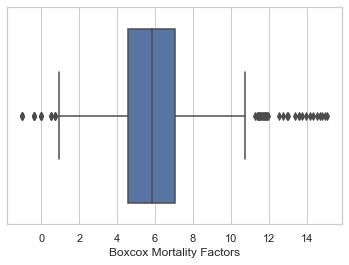

Jarque-Bera test statistics is 186.35808430220982 and p value is 0.0
Normality test statistics is 78.7735368033197 and p value is 7.844112671231939e-18


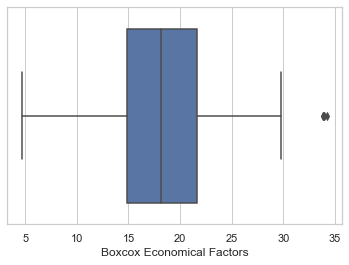

Jarque-Bera test statistics is 16.655708635602576 and p value is 0.00024169007901164719
Normality test statistics is 24.7457337694471 and p value is 4.2318687198300125e-06


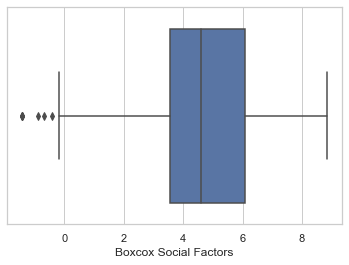

Jarque-Bera test statistics is 23.391290164020738 and p value is 8.330016824764641e-06
Normality test statistics is 37.86303906456608 and p value is 5.99992101313181e-09


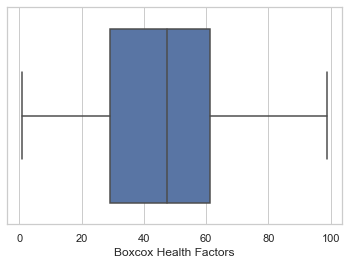

Jarque-Bera test statistics is 111.85564667726096 and p value is 0.0
Normality test statistics is 246.67778450614128 and p value is 2.720192823010153e-54


In [54]:
factors_list = ['Disease Factors', 'Mortality Factors', 'Economical Factors', 'Social Factors', 'Health Factors']

for col in factors_list:
    boxcox_column_name = 'Boxcox {}'.format(col)
    clean_lifeexpectancy_df[boxcox_column_name],_ = boxcox(clean_lifeexpectancy_df[col])

    sns.boxplot(clean_lifeexpectancy_df[boxcox_column_name])
    plt.show()
    
    jb_stats = jarque_bera(clean_lifeexpectancy_df[boxcox_column_name])
    norm_stats = normaltest(clean_lifeexpectancy_df[boxcox_column_name])

    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    

A few observations after transforming our factor variables:

- Economical and Social Factors became statistically significant within a p value of 0.05 on both normality tests.
- Health, Disease, and Mortality did not meet our statistical normality tests (which could be a flag that there are many outliers that are still skewing the analysis)

## Next we'll run a corelation analysis against our target to see what could be promising

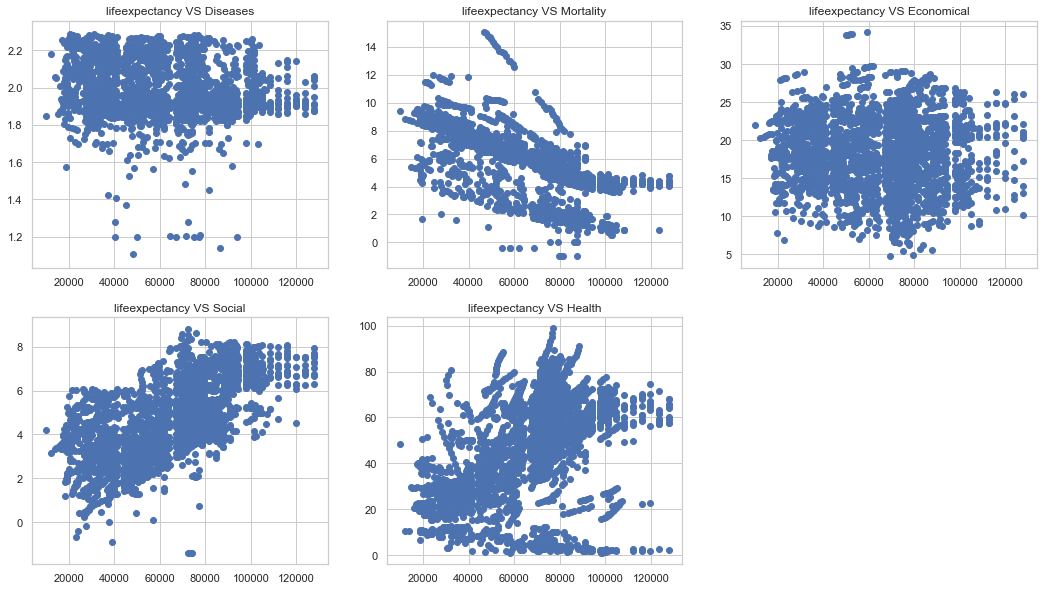

In [62]:
plt.figure(figsize=(18,10))

plt.subplot(231)
plt.scatter(clean_lifeexpectancy_df['Boxcox Life expectancy'], clean_lifeexpectancy_df['Boxcox Disease Factors'])
plt.title('lifeexpectancy VS Diseases')

plt.subplot(232)
plt.scatter(clean_lifeexpectancy_df['Boxcox Life expectancy'], clean_lifeexpectancy_df['Boxcox Mortality Factors'])
plt.title('lifeexpectancy VS Mortality')

plt.subplot(233)
plt.scatter(clean_lifeexpectancy_df['Boxcox Life expectancy'], clean_lifeexpectancy_df['Boxcox Economical Factors'])
plt.title('lifeexpectancy VS Economical')

plt.subplot(234)
plt.scatter(clean_lifeexpectancy_df['Boxcox Life expectancy'], clean_lifeexpectancy_df['Boxcox Social Factors'])
plt.title('lifeexpectancy VS Social')

plt.subplot(235)
plt.scatter(clean_lifeexpectancy_df['Boxcox Life expectancy'], clean_lifeexpectancy_df['Boxcox Health Factors'])
plt.title('lifeexpectancy VS Health')

plt.show()

In [64]:
clean_lifeexpectancy_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Log Disease Factors,Boxcox Life expectancy,Mortality Factors,Economical Factors,Social Factors,Health Factors,Boxcox Mortality Factors,Boxcox Economical Factors,Boxcox Social Factors,Boxcox Health Factors
Year,1.000000,0.170033,-0.079052,-0.036464,-0.059946,0.032723,0.144050,-0.081840,0.095834,-0.041980,...,-0.126438,0.165359,-0.066312,0.020741,0.061895,0.094056,-0.067206,0.034258,0.072526,0.112682
Life expectancy,0.170033,1.000000,-0.696359,-0.196557,0.400419,0.381864,0.245161,-0.157586,0.560932,-0.222529,...,-0.267166,0.988468,-0.462214,-0.007175,0.620749,0.409966,-0.631013,-0.032918,0.621482,0.450038
Adult Mortality,-0.079052,-0.696359,1.000000,0.078756,-0.196126,-0.242860,-0.157772,0.031176,-0.384293,0.094146,...,0.134047,-0.677777,0.472361,-0.025586,-0.349712,-0.288768,0.774759,0.032407,-0.349237,-0.322496
infant deaths,-0.036464,-0.196557,0.078756,1.000000,-0.116026,-0.085906,-0.210683,0.501038,-0.226701,0.996628,...,0.477824,-0.200372,0.914913,0.538505,-0.164492,-0.020320,0.510451,0.233325,-0.164175,-0.019160
Alcohol,-0.059946,0.400419,-0.196126,-0.116026,1.000000,0.337739,0.087906,-0.051238,0.327174,-0.113237,...,-0.148672,0.436756,-0.178746,-0.029737,0.892601,0.164348,-0.266823,0.004203,0.872462,0.177705
percentage expenditure,0.032723,0.381864,-0.242860,-0.085906,0.337739,1.000000,-0.043465,-0.056831,0.230628,-0.088152,...,-0.084550,0.430197,-0.173092,-0.016241,0.406064,0.137481,-0.283392,0.031613,0.390085,0.149657
Hepatitis B,0.144050,0.245161,-0.157772,-0.210683,0.087906,-0.043465,1.000000,-0.153624,0.177546,-0.220286,...,-0.092664,0.230078,-0.253753,-0.082653,0.153985,0.130951,-0.222379,-0.019218,0.160899,0.144015
Measles,-0.081840,-0.157586,0.031176,0.501038,-0.051238,-0.056831,-0.153624,1.000000,-0.175410,0.507718,...,0.652895,-0.149936,0.459408,0.229687,-0.076015,-0.090377,0.324511,0.098313,-0.074348,-0.096511
BMI,0.095834,0.560932,-0.384293,-0.226701,0.327174,0.230628,0.177546,-0.175410,1.000000,-0.237050,...,-0.290265,0.558535,-0.357741,-0.060562,0.466509,0.897772,-0.456595,-0.029247,0.464538,0.906616
under-five deaths,-0.041980,-0.222529,0.094146,0.996628,-0.113237,-0.088152,-0.220286,0.507718,-0.237050,1.000000,...,0.482781,-0.223100,0.921444,0.526058,-0.170638,-0.031630,0.520399,0.236390,-0.170945,-0.031725


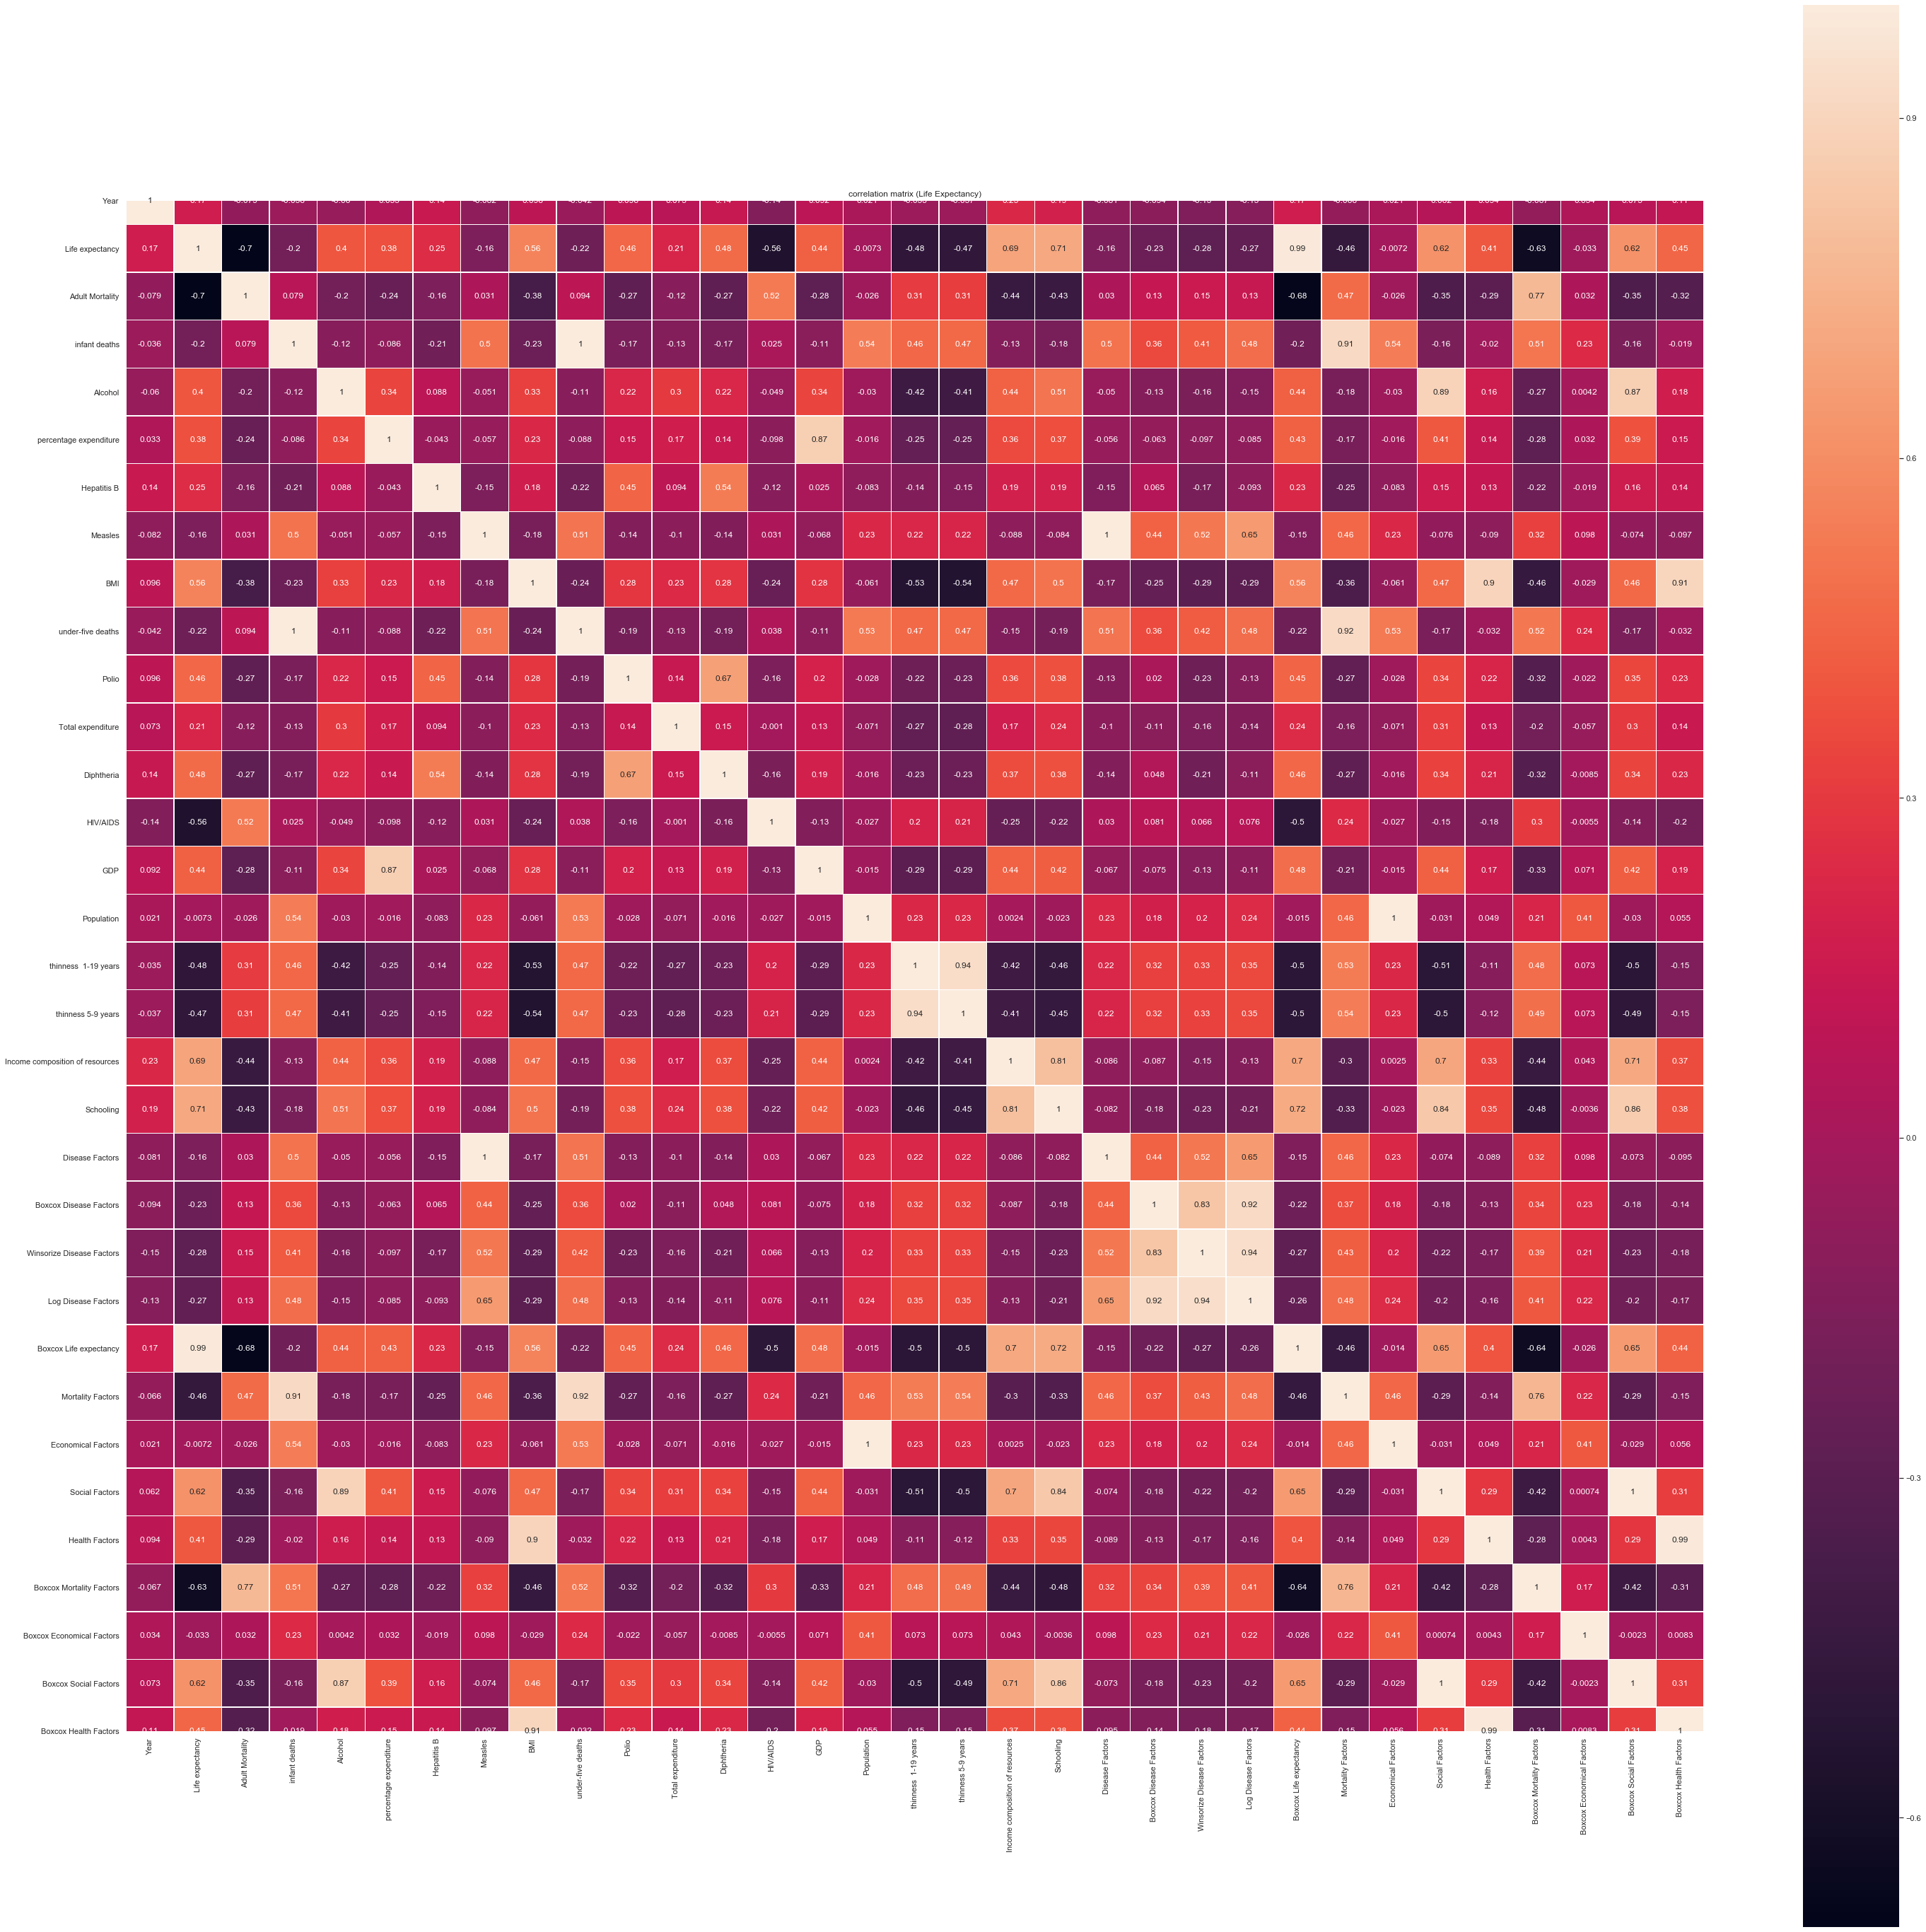

In [67]:
corrmat_lifeexp = clean_lifeexpectancy_df.corr()

plt.figure(figsize=(50, 50))

sns.heatmap(corrmat_lifeexp, square=True, annot=True, linewidths=.5)
plt.title('correlation matrix (Life Expectancy)')

plt.show()

In [75]:
X = clean_lifeexpectancy_df[['Boxcox Life expectancy', 'Boxcox Social Factors', 'Boxcox Mortality Factors']]
X.corr()

,Boxcox Life expectancy,Boxcox Social Factors,Boxcox Mortality Factors
Boxcox Life expectancy,1.000000,0.649711,-0.635256
Boxcox Social Factors,0.649711,1.000000,-0.419331
Boxcox Mortality Factors,-0.635256,-0.419331,1.000000


## After analyzing the Correlation Matrix Heatmap we chose to use _Boxcox Social Factors_ that has a corr of ~0.65 positive correlation and _Boxcox Mortality Factors_ that has a corr of ~(0.64) negative correlation to our target variable. 

## These will be the variables that we generate our features for our model from.

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = clean_lifeexpectancy_df[['Boxcox Social Factors', 'Boxcox Mortality Factors']]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
clean_lifeexpectancy_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.70966569]


We can see that the _pca_1_ component is **greater than** our inital factor variables that we chose based on those having the highest level of correlation to start!

In [79]:
X = clean_lifeexpectancy_df[['pca_1', 'Boxcox Life expectancy', 'Boxcox Social Factors', 'Boxcox Mortality Factors']]
X.corr()

,pca_1,Boxcox Life expectancy,Boxcox Social Factors,Boxcox Mortality Factors
pca_1,1.000000,-0.762668,-0.842417,0.842417
Boxcox Life expectancy,-0.762668,1.000000,0.649711,-0.635256
Boxcox Social Factors,-0.842417,0.649711,1.000000,-0.419331
Boxcox Mortality Factors,0.842417,-0.635256,-0.419331,1.000000


# In summary I would leverage the new component as part of my model moving forward as it will most likely produce the highest quality forecasts and reduce our margins of error moving forward.